In [1]:
%matplotlib inline
import hashlib
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size


D = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

N = 1024
Z = 8

M = len(D)

MAX_ITER = 1000

def hamming(x_k, x_l):
    return np.mean(x_k != x_l)

In [2]:
class Encoder(object):
    
    
    def __init__(self, seed, d, n, z, gam):
        self.seed = seed
        self.d = d
        self.m = len(d)
        
        self.n = n
        self.z = z
        self.gam = gam
        
        # sample basis and mask function aux var
        np.random.seed(seed)
        self.x_star = np.random.randint(0, z, n)
        self.xs = [np.random.randint(0, z, n) for i in range (self.m)]
        
        self.seed_offset = np.random.randint(0, 2**32-1)
    
    
    def veil(self, x_k, x_l):
        # get unique RNG seed from x_k and x_l
        str_repr = ''.join(x_k.astype(str)) + ''.join(x_l.astype(str))
        rng_seed = int(hashlib.sha256(str_repr.encode('utf-8')).hexdigest(), 16)  % 10**9
        
        np.random.seed((rng_seed + self.seed_offset)%(2**32))
        
        return np.random.rand(len(x_k))
    
    
    def weave(self, x_k, x_l, t):
        mask = self.veil(x_k, x_l) < 1/(t+1)**self.gam
        u = x_k.copy()
        u[mask] = x_l[mask]
        return u
    
    
    def encode(self, s):
        y = self.x_star.copy()
        
        for t_, a in enumerate(s):
            t = t_+1
            idx = self.d.index(a)
            y = self.weave(y, self.xs[idx], t)
            
        return y
    
    
    # functions for exact calculation
    def smty_seq_sbl(self, y, s_i):
        if self.gam != 1:
            raise NotImplementedError
        
        n_i = np.sum(np.array([y_ for y_ in y], dtype='<U1') == s_i)
        l = len(y)
        
        q = n_i/(l+1) + (1/self.z) * (l + 1 - n_i)/(l + 1)

        return q, q*(1-q)/self.n
    
    
    def smty_seq_seq(self, y, y_):
        if self.gam != 1:
            raise NotImplementedError
        
        # get seq lens and shared starting subseq len (t)
        l = len(y)
        l_ = len(y_)
        t = 0
        for s, s_ in zip(y, y_):
            if s == s_:
                t += 1
            else:
                break
        
        assert np.all(y[:t] == y_[:t])
        
        # convert seqs to arrays
        y = np.array([yy for yy in y], dtype='<U1')
        y_ = np.array([yy for yy in y_], dtype='<U1')

        # get symbol count vecs
        n_u = [np.sum(y[:t] == self.d[i]) for i in range(self.m)]
        n_v = [np.sum(y[t:] == self.d[i]) for i in range(self.m)]
        n_v_ = [np.sum(y_[t:] == self.d[i]) for i in range(self.m)]
        
        # calc case probabilites from ms section 4.2
        p_1 = (t+1)**2 / ((l+1)*(l_+1))
        
        p_2 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_v_) + ((l-t)*(l_-t) - np.dot(n_v, n_v_)) * (1/self.z) )
        
        p_3 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_u, n_v_) + ((t+1)*(l_-t) - np.dot(n_u, n_v_)) * (1/self.z) )
        
        p_4 = 1 / ((l+1)*(l_+1)) * \
            ( np.dot(n_v, n_u) + ((l-t)*(t+1) - np.dot(n_v, n_u)) * (1/self.z) )
        
        # sum case probabilities
        q = p_1 + p_2 + p_3 + p_4
        
        return q, q*(1-q)/self.n
    
    
class Decoder(object):
    
    def __init__(self, encoder):
        self.e = encoder
        
    
    def decode(self, y, l=None, return_dst=False, force=None, max_iter=MAX_ITER):
        
        # get set of elements in sequence
        min_idxs = np.argsort([hamming(x, y) for x in self.e.xs])
        vs = [self.e.xs[idx] for idx in min_idxs]
        
        # reconstruct sequence
        y_star = self.e.x_star.copy()
        s_hat = ''
        dst = [hamming(y_star, y)]
        
        for t in range(1, max_iter):
            
            us = [self.e.weave(y_star, v, t) for v in vs]
            dst_ = [hamming(u, y) for u in us]
            j = np.argmin(dst_)
            
            if l is None and dst_[j] >= dst[-1]:
                break

            if force is not None and len(force) >= t:
                next_sym = force[t-1]
                next_x = self.e.xs[self.d.index(next_sym)]
            else:
                next_sym = self.e.d[min_idxs[j]]
                next_x = vs[j]

            s_hat += next_sym
            y_star = self.e.weave(y_star, next_x, t)
            dst.append(hamming(y_star, y))
            
            if t == l:
                break

        if not return_dst:
            return s_hat
        else:
            return s_hat, np.array(dst)

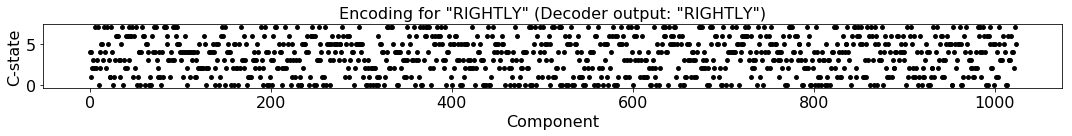

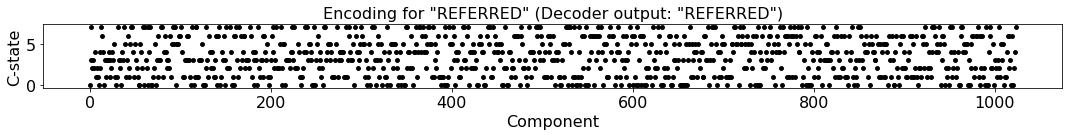

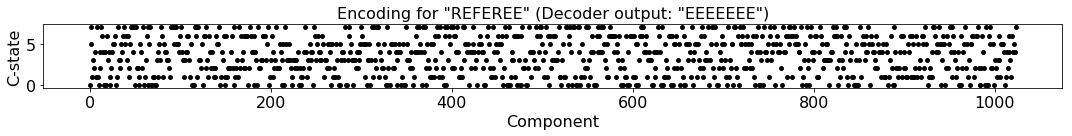

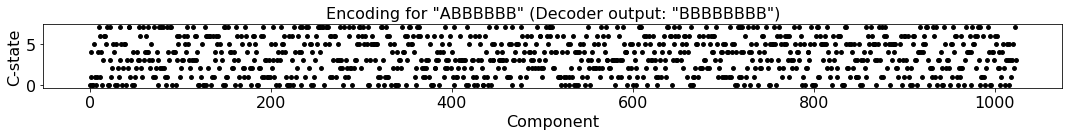

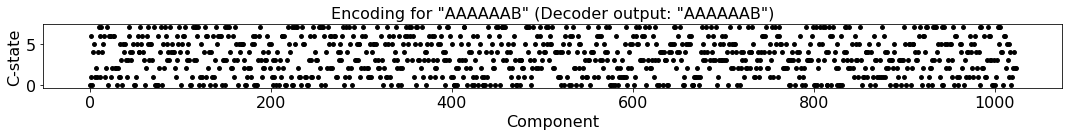

In [3]:
encoder = Encoder(0, D, N, Z, 1)
decoder = Decoder(encoder)

for y in ['RIGHTLY', 'REFERRED', 'REFEREE', 'ABBBBBB', 'AAAAAAB']:

    x = encoder.encode(y)
    fig, ax = plt.subplots(1, 1, figsize=(15, 2), tight_layout=True)
    ax.scatter(range(len(x)), x, s=15, c='k')
    ax.set_xlabel('Component')
    ax.set_ylabel('C-state')
    ax.set_title('Encoding for "{}" (Decoder output: "{}")'.format(y, decoder.decode(x)))
    set_font_size(ax, 16)

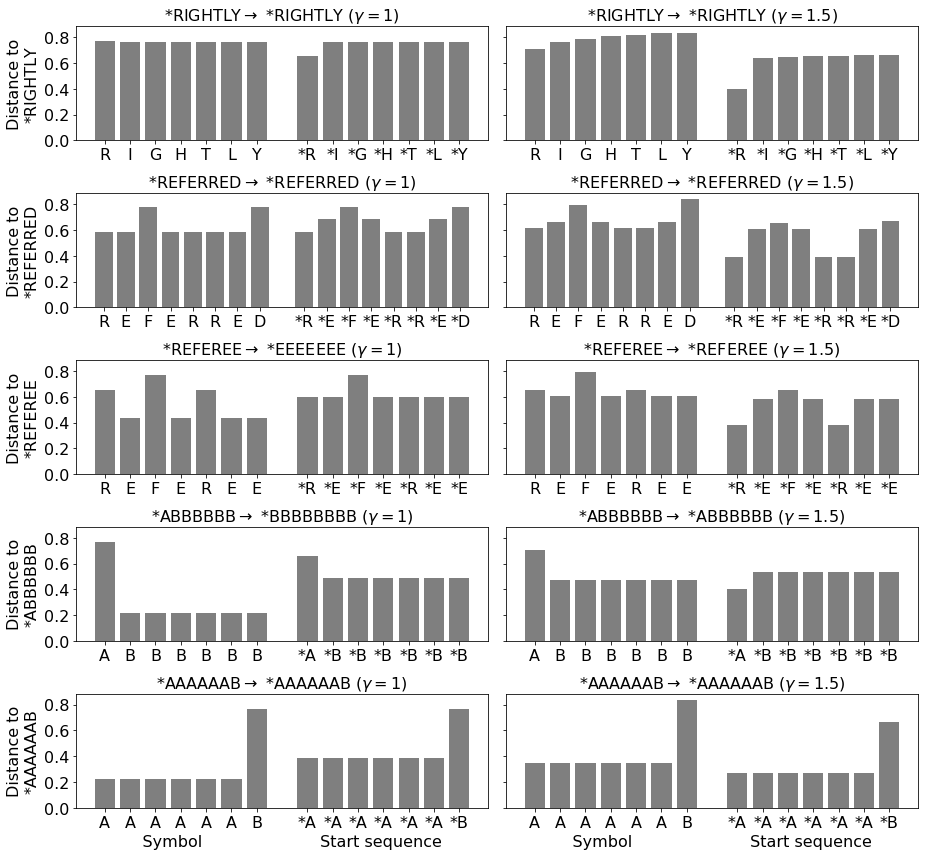

In [4]:
ys = ['RIGHTLY', 'REFERRED', 'REFEREE', 'ABBBBBB', 'AAAAAAB']
n_trial = 100
gam = [1, 1.5]

p_correct = np.nan * np.zeros((len(gam), len(ys)))

fig, axs = plt.subplots(len(ys), 2, figsize=(13, 12), tight_layout=True, sharey=True)

for g_ctr, (gam_, ax_col) in enumerate(zip(gam, axs.T)):
    
    for y_ctr, (y, ax) in enumerate(zip(ys, ax_col)):
        sbl = np.array([sbl_ for sbl_ in y])
        seq = sbl.copy()

        dst_sbl = np.nan * np.zeros((n_trial, len(sbl)))
        dst_seq = np.nan * np.zeros((n_trial, len(seq)))

        ct_correct = 0
        
        y_hat = None
        
        for seed in range(n_trial):
            encoder = Encoder(seed, D, N, Z, gam_)
            decoder = Decoder(encoder)

            x = encoder.encode(y)

            for ctr, sbl_ in enumerate(sbl):
                dst_sbl[seed, ctr] = hamming(x, encoder.xs[D.index(sbl_)])

            for ctr, seq_ in enumerate(seq):
                dst_seq[seed, ctr] = hamming(x, encoder.encode(seq_))

            if decoder.decode(x) == y:
                ct_correct += 1
                
            if seed == 0:
                y_hat = decoder.decode(x)

        p_correct[g_ctr, y_ctr] = ct_correct/n_trial

        ax.bar(
            np.arange(len(sbl)*2+1),
            np.concatenate([dst_sbl.mean(0), [0], dst_seq.mean(0)]), color='k', alpha=.5)

        ax.set_xticks(list(np.arange(len(sbl))) + list(np.arange(len(sbl)+1, 2*len(sbl)+1)))
        ax.set_xticklabels(list(sbl) + ['*' + seq_ for seq_ in seq])
        if y_ctr == len(ys) - 1:
            ax.set_xlabel('    Symbol                       Start sequence')
        if g_ctr == 0:
            ax.set_ylabel('Distance to\n*{}'.format(y))
        ax.set_title('*' + y + r'$\rightarrow$ *' + y_hat + r' ($\gamma = $' + '{})'.format(gam_))

        set_font_size(ax, 16)

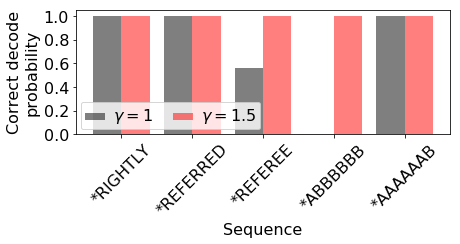

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5), tight_layout=True)
ax.bar(np.arange(len(ys)) - .2, p_correct[0, :], width=.4, color='k', alpha=.5)
ax.bar(np.arange(len(ys)) + .2, p_correct[1, :], width=.4, color='r', alpha=.5)

ax.set_xlabel('Sequence')
ax.set_xticks(np.arange(len(ys)))
ax.set_xticklabels(['*' + y for y in ys], rotation=45)
ax.set_ylabel('Correct decode\nprobability')
ax.legend([r'$\gamma = $'+'{}'.format(gam_) for gam_ in gam], ncol=2, loc='lower left')

set_font_size(ax, 16)